In [69]:
import pandas as pd
import numpy as np
from scipy.special import boxcox1p, inv_boxcox1p
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error as mse

In [70]:
#import the data
train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')

test_ID = test_df['Id']

train_df.drop("Id", axis = 1, inplace = True)
test_df.drop("Id", axis = 1, inplace = True)

# EDA

In [30]:
# test data
test_df.describe().T[['min','mean','max']]

,min,mean,max
MSSubClass,20.0,57.378341,190.0
LotFrontage,21.0,68.580357,200.0
LotArea,1470.0,9819.161069,56600.0
OverallQual,1.0,6.078821,10.0
OverallCond,1.0,5.553804,9.0
YearBuilt,1879.0,1971.357779,2010.0
YearRemodAdd,1950.0,1983.662783,2010.0
MasVnrArea,0.0,100.709141,1290.0
BsmtFinSF1,0.0,439.203704,4010.0
BsmtFinSF2,0.0,52.619342,1526.0


In [31]:
#unique values for categorical data (nan included)
list_categorical=train_df.dtypes[train_df.dtypes == "object"].index
value_counts_list=[]
for cat_feature in list_categorical:
    value_counts_list.append(cat_feature)
    value_counts_list.append((train_df[cat_feature].value_counts(dropna=False).to_dict()))

value_counts_list

['MSZoning',
 {'C (all)': 10, 'FV': 65, 'RH': 16, 'RL': 1151, 'RM': 218},
 'Street',
 {'Grvl': 6, 'Pave': 1454},
 'Alley',
 {'Grvl': 50, 'Pave': 41, nan: 1369},
 'LotShape',
 {'IR1': 484, 'IR2': 41, 'IR3': 10, 'Reg': 925},
 'LandContour',
 {'Bnk': 63, 'HLS': 50, 'Low': 36, 'Lvl': 1311},
 'Utilities',
 {'AllPub': 1459, 'NoSeWa': 1},
 'LotConfig',
 {'Corner': 263, 'CulDSac': 94, 'FR2': 47, 'FR3': 4, 'Inside': 1052},
 'LandSlope',
 {'Gtl': 1382, 'Mod': 65, 'Sev': 13},
 'Neighborhood',
 {'Blmngtn': 17,
  'Blueste': 2,
  'BrDale': 16,
  'BrkSide': 58,
  'ClearCr': 28,
  'CollgCr': 150,
  'Crawfor': 51,
  'Edwards': 100,
  'Gilbert': 79,
  'IDOTRR': 37,
  'MeadowV': 17,
  'Mitchel': 49,
  'NAmes': 225,
  'NPkVill': 9,
  'NWAmes': 73,
  'NoRidge': 41,
  'NridgHt': 77,
  'OldTown': 113,
  'SWISU': 25,
  'Sawyer': 74,
  'SawyerW': 59,
  'Somerst': 86,
  'StoneBr': 25,
  'Timber': 38,
  'Veenker': 11},
 'Condition1',
 {'Artery': 48,
  'Feedr': 81,
  'Norm': 1260,
  'PosA': 8,
  'PosN': 19,
  'RR

In [32]:
#nan counts for all features
train_df.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageCond        81
GarageFinish      81
GarageQual        81
GarageYrBlt       81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
RoofMatl           0
dtype: int64

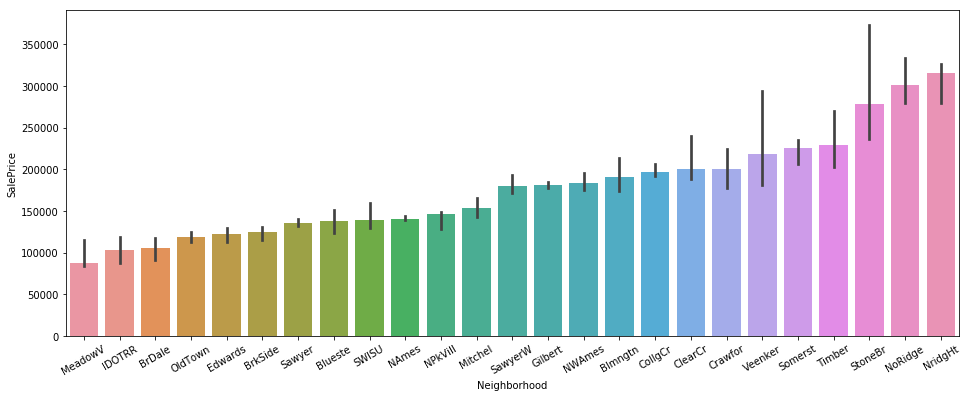

In [33]:
plt.figure(figsize=(16,6))
plt.xticks(rotation=30)
result = train_df.groupby("Neighborhood")['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
sns.barplot(x='Neighborhood', y='SalePrice', estimator=np.median, data=train_df, order=result['Neighborhood'])

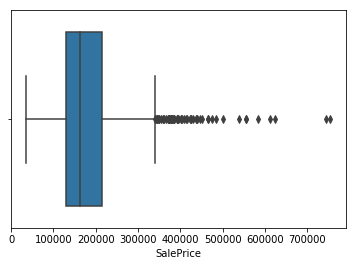

In [34]:
sns.boxplot(train_df['SalePrice'])

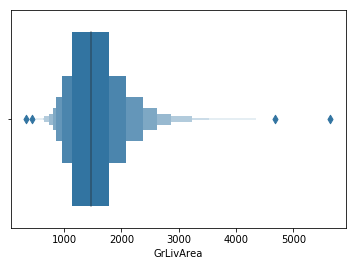

In [35]:
sns.boxenplot(train_df['GrLivArea'])

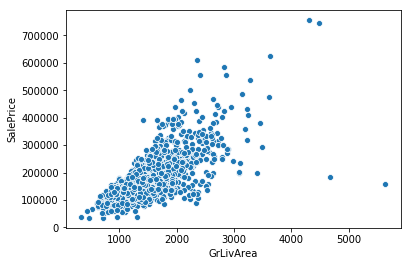

In [36]:
#check two outliers
sns.scatterplot(x=train_df['GrLivArea'], y=train_df['SalePrice'])

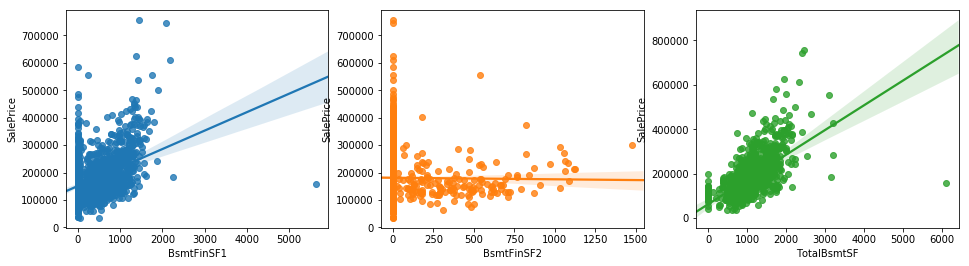

In [37]:
fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(16,4))
sns.regplot(x='BsmtFinSF1', y='SalePrice',data=train_df, ax=axes[0])
sns.regplot(x='BsmtFinSF2', y='SalePrice',data=train_df, ax=axes[1])
sns.regplot(x='TotalBsmtSF', y='SalePrice',data=train_df, ax=axes[2])

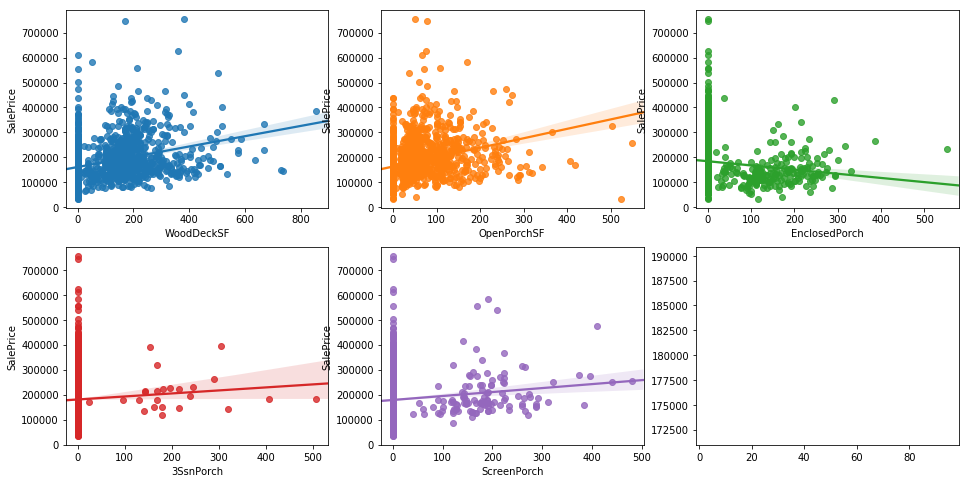

In [38]:
fig, axes = plt.subplots(nrows=2,ncols=3, figsize=(16,8))
sns.regplot(x='WoodDeckSF', y='SalePrice',data=train_df, ax=axes[0,0])
sns.regplot(x='OpenPorchSF', y='SalePrice',data=train_df, ax=axes[0,1])
sns.regplot(x='EnclosedPorch', y='SalePrice',data=train_df, ax=axes[0,2])
sns.regplot(x='3SsnPorch', y='SalePrice',data=train_df, ax=axes[1,0])
sns.regplot(x='ScreenPorch', y='SalePrice',data=train_df, ax=axes[1,1])

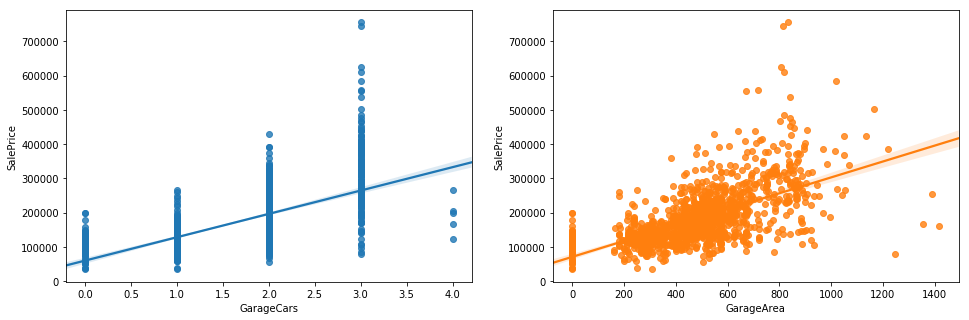

In [39]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(16,5))
sns.regplot(x='GarageCars', y='SalePrice',data=train_df, ax=axes[0])
sns.regplot(x='GarageArea', y='SalePrice',data=train_df, ax=axes[1])

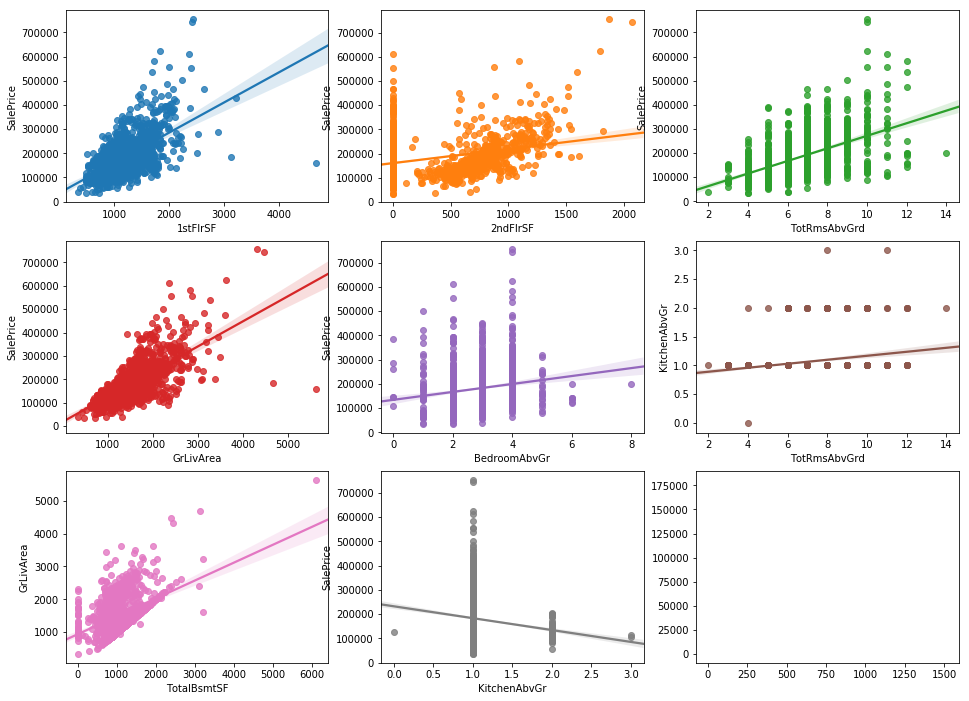

In [40]:
fig, axes = plt.subplots(nrows=3,ncols=3, figsize=(16,12))
sns.regplot(x='1stFlrSF', y='SalePrice',data=train_df, ax=axes[0,0])
sns.regplot(x='2ndFlrSF', y='SalePrice',data=train_df, ax=axes[0,1])
sns.regplot(x='TotRmsAbvGrd', y='SalePrice',data=train_df, ax=axes[0,2])
sns.regplot(x='GrLivArea', y='SalePrice',data=train_df, ax=axes[1,0])
sns.regplot(x='BedroomAbvGr', y='SalePrice',data=train_df, ax=axes[1,1])
sns.regplot(x='TotRmsAbvGrd', y='KitchenAbvGr',data=train_df, ax=axes[1,2])
sns.regplot(x='TotalBsmtSF', y='GrLivArea',data=train_df, ax=axes[2,0])
sns.regplot(x='KitchenAbvGr', y='SalePrice',data=train_df, ax=axes[2,1])

# Preprocessing

In [71]:
# functin to take care of all preprocessing for train (df) and test data (dft)
def preprocessing_train(df,dft):
    df.drop(['Utilities'], axis=1,inplace=True) # 'AllPub' for all entries
    df.drop(index=(df[(df['SalePrice']<300000) & (df['GrLivArea']>4000)].index), inplace=True)
    df['MSSubClass'] = df['MSSubClass'].apply(str) # should not be a numeric feature
    
    dft.drop(['Utilities'], axis=1,inplace=True) 
    dft['MSSubClass'] = dft['MSSubClass'].apply(str) 
    
    #ordinal_features
    ordinal_features_qual1=['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','FireplaceQu','GarageQual',
     'GarageCond','PoolQC']
    
    neighborhood_dict = {
            "MeadowV" : 0,"IDOTRR" : 0,"BrDale": 0,
            "OldTown":1,"Edwards":1,"BrkSide" : 1,
            "Sawyer" : 2, "Blueste" : 2,"SWISU" : 2, "NAmes" : 2,"NPkVill" : 2,"Mitchel" : 2,
            "SawyerW" : 3,"Gilbert" : 3, "NWAmes" : 3,"Blmngtn" : 3,"CollgCr" : 3, "ClearCr" : 3,"Crawfor" : 3,
            "Veenker" : 4,"Somerst" : 4,"Timber" : 4,
            "StoneBr" : 5,"NoRidge" : 5, "NridgHt" : 5,
        }

    # converting ordinal features to numeric 
    for col_name in ordinal_features_qual1:
            df[col_name]=df[col_name].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1, np.nan:0}).astype(int)

    df[['OverallQual','OverallCond']]=df[['OverallQual','OverallCond']].astype(int)
    df['BsmtExposure']=df['BsmtExposure'].map({'Gd': 4,'Av': 3,'Mn': 2, 'No': 1, np.nan:0}).astype(int)
    df['BsmtFinType1']=df['BsmtFinType1'].map({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,np.nan:0}).astype(int)
    df['BsmtFinType2']=df['BsmtFinType2'].map({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,np.nan:0}).astype(int)
    df['Functional']=df['Functional'].map({'Typ':6,'Min1':5,'Min2':4,'Mod':3,'Maj1':2,'Maj2':1,'Sev':0,np.nan:0}).astype(int)
    df['GarageFinish']=df['GarageFinish'].map({'Fin':3, 'RFn':2, 'Unf':1, np.nan:0}).astype(int)
    df['Fence']=df['Fence'].map({'GdPrv': 4, 'MnPrv': 3,'GdWo': 2,'MnWw': 1, np.nan:0}).astype(int)
    df['Neighborhood_group']=df['Neighborhood'].map(neighborhood_dict).astype(int)

    # creating two new features!
    df['Cumulative_condition']=(df['ExterQual']+df['ExterCond']+ \
            df['HeatingQC']+df['KitchenQual']+ \
            df['FireplaceQu']+df['GarageQual']+df['GarageCond']+df['GarageFinish']+ \
            df['PoolQC']+df['OverallQual']+df['OverallCond'] )*df['OverallQual']
    

    df['Cumulative_Bst']=(df['BsmtExposure']+df['BsmtFinType1']+df['BsmtFinType2']+ \
        df['BsmtQual']+df['BsmtCond'])*df['BsmtQual']
    
    #Test data
    for col_name in ordinal_features_qual1:
                dft[col_name]=dft[col_name].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1, np.nan:0}).astype(int)

    dft[['OverallQual','OverallCond']]=dft[['OverallQual','OverallCond']].astype(int)
    dft['BsmtExposure']=dft['BsmtExposure'].map({'Gd': 4,'Av': 3,'Mn': 2, 'No': 1, np.nan:0}).astype(int)
    dft['BsmtFinType1']=dft['BsmtFinType1'].map({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,np.nan:0}).astype(int)
    dft['BsmtFinType2']=dft['BsmtFinType2'].map({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,np.nan:0}).astype(int)
    dft['Functional']=dft['Functional'].map({'Typ':6,'Min1':5,'Min2':4,'Mod':3,'Maj1':2,'Maj2':1,'Sev':0,np.nan:0}).astype(int)
    dft['GarageFinish']=dft['GarageFinish'].map({'Fin':3, 'RFn':2, 'Unf':1, np.nan:0}).astype(int)
    dft['Fence']=dft['Fence'].map({'GdPrv': 4, 'MnPrv': 3,'GdWo': 2,'MnWw': 1, np.nan:0}).astype(int)
    dft['Neighborhood_group']=dft['Neighborhood'].map(neighborhood_dict).astype(int)


    dft['Cumulative_condition']=(dft['ExterQual']+dft['ExterCond']+ \
                dft['HeatingQC']+dft['KitchenQual']+ \
                dft['FireplaceQu']+dft['GarageQual']+dft['GarageCond']+dft['GarageFinish']+ \
                dft['PoolQC']+dft['OverallQual']+dft['OverallCond'] )*dft['OverallQual']


    dft['Cumulative_Bst']=(dft['BsmtExposure']+dft['BsmtFinType1']+dft['BsmtFinType2']+ \
            dft['BsmtQual']+dft['BsmtCond'])*dft['BsmtQual']


    #Encoded_categorical
    #Encoding categorical data. Note YrSold and MoSold
    df['Alley'].fillna(value='NoAlley',inplace=True)
    dft['Alley'].fillna(value='NoAlley',inplace=True)
    
    encod_list='Alley,CentralAir,LandSlope,LotShape,PavedDrive,Street,YrSold,MoSold'.split(',')
    for c in encod_list:
        lbl=LabelEncoder()
        uniqe_cat=list(df[c].unique())+list(dft[c].unique())
        # fitting on training data only
        lbl.fit(uniqe_cat)
        df[c]=lbl.transform(df[c])
        dft[c]=lbl.transform(dft[c])
   
        
    #numerical_features --------------------------------------------
    
    #filling nan for LotFrontage based on the Neighborhood
    LotF_in_Nb=df.groupby('Neighborhood')['LotFrontage'].median()
    df['LotFrontage']=df[['Neighborhood','LotFrontage']].apply(lambda x: LotF_in_Nb[x['Neighborhood']] if np.isnan(x['LotFrontage']) else x['LotFrontage'], axis=1)
    df['GarageYrBlt'].fillna(value=0, inplace=True)
    df['MasVnrArea'].fillna(value=0, inplace=True)
    
    #creating two new features
    df['All_Bath']=df['BsmtFullBath']+df['BsmtHalfBath']+df['FullBath']+df['HalfBath']
    df['Total_Porch']=df['WoodDeckSF']+df['OpenPorchSF']+df['EnclosedPorch']+ \
                            df['3SsnPorch']+df['ScreenPorch']

    #test_data
    LotF_in_Nb=dft.groupby('Neighborhood')['LotFrontage'].median()
    dft['LotFrontage']=dft[['Neighborhood','LotFrontage']].apply(lambda x: LotF_in_Nb[x['Neighborhood']] if np.isnan(x['LotFrontage']) else x['LotFrontage'], axis=1)
    dft['GarageYrBlt'].fillna(value=0, inplace=True)
    dft['MasVnrArea'].fillna(value=0, inplace=True)
    dft['GarageCars'].fillna(value=0, inplace=True)
    dft['GarageArea'].fillna(value=0, inplace=True)
    dft.loc[dft['GarageYrBlt'].idxmax(),'GarageYrBlt']=2007 #it was 2207, errornous data 
    
    dft['All_Bath']=dft['BsmtFullBath']+dft['BsmtHalfBath']+dft['FullBath']+dft['HalfBath']
    dft['Total_Porch']=dft['WoodDeckSF']+dft['OpenPorchSF']+dft['EnclosedPorch']+ \
                            dft['3SsnPorch']+dft['ScreenPorch']
    missings=['All_Bath', 'BsmtHalfBath', 'BsmtFullBath', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFinSF1']
    for mis in missings:
        dft[mis].fillna(value=0,inplace=True)
    #-------        
    dft['SalePrice']=0
    numerical_features=df.dtypes[df.dtypes != 'object'].index   
    # data normalization using boxcox transformation
    for num_c in numerical_features:
        if abs(df[num_c].skew()) > 0.75:
            df[num_c]=boxcox1p(df[num_c], 0.15)
            dft[num_c]=boxcox1p(dft[num_c], 0.15)
            
 
    #non-ordinal categorical
    df['MasVnrType'].fillna(value='NoVn',inplace=True)
    df['Electrical'].fillna(value='SBrkr',inplace=True)
    df['GarageType'].fillna(value='NoGar',inplace=True)
    df['MiscFeature'].fillna(value='None',inplace=True)
    
    # creating dummies for the remaining categorical features
    df = pd.get_dummies(df)
    
    #test_data
    #non-ordinal categorical
    dft['Exterior2nd'].fillna(value='VinylSd',inplace=True)
    dft['MSZoning'].fillna(value='RL',inplace=True)
    dft['MiscFeature'].fillna(value='None',inplace=True)
    dft['MasVnrType'].fillna(value='NoVn',inplace=True)
    dft['Electrical'].fillna(value='SBrkr',inplace=True)
    dft['GarageType'].fillna(value='NoGar',inplace=True)
    
    dft = pd.get_dummies(dft)
   
    return df, dft, numerical_features


In [72]:
train, test, numerical_features =preprocessing_train(df=train_df,dft=test_df)

In [73]:
# deleting extra columns in test data (caused by new values of categorical features!)_Not sure
extra_test_columns=test.columns.difference(train.columns)
test.drop(extra_test_columns,axis=True, inplace=True)
#-----
# creating zero columns for missing features in the test data (caused by values of categorical features only in train data)
missing_test_columns= train.columns.difference(test.columns)
for miss_col in missing_test_columns:
    test[miss_col]=0

test.drop('SalePrice', axis=1, inplace=True)
print('train data:',train.shape)
print ('test data:', test.shape)

#must be> train data: (1458, 240)
#must be> test data: (1459, 239)

train data: (1458, 240)
test data: (1459, 239)


In [74]:
X=train.drop('SalePrice',axis=1)
y=train['SalePrice']

In [75]:
# to be used by the for loop for standardization. The target shouldn't be included. 
numerical_features=numerical_features.tolist()
del numerical_features [numerical_features.index('SalePrice')]

In [76]:
scaled_X=X
scaled_test=test

#dummies and ordinal features are excluded in scaling (Not sure)
for col in numerical_feat:
    scaler=RobustScaler()
    scaler.fit(X[[col]])
    scaled_X[col]=scaler.transform(X[[col]])
    
    scaled_test[col]=scaler.transform(scaled_test[[col]])
'''    
    
scaler=RobustScaler()
scaler.fit(X)
scaled_X=pd.DataFrame(scaler.transform(X), index=X.index, columns=X.columns)
scaled_test=pd.DataFrame(scaler.transform(test), index=test.index, columns=test.columns)
'''
X_train,X_test, y_train, y_test=train_test_split(scaled_X, y, test_size=0.3)

# Data Modeling

In [77]:
reg_lasso=Lasso(alpha=0.00045, max_iter=50000)
reg_lasso.fit(X_train,y_train)
prediction_lasso=reg_lasso.predict(X_test)
print (mse(y_test,prediction_lasso))

0.42680222931419604


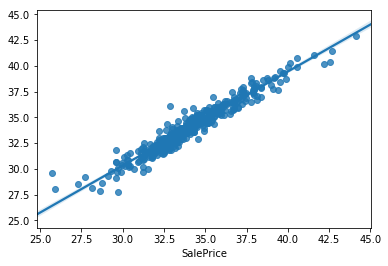

In [86]:
sns.regplot(y_test, prediction_lasso)

In [ ]:
#did it only for Lasso.
'''
from sklearn.model_selection import GridSearchCV
parameters=[{'alpha':[0.0042,0.0045,0.0048]}]

grid_search=GridSearchCV(estimator=reg_lasso,param_grid=parameters, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
grid_search=grid_search.fit(X_train,y_train)
grid_search.best_params_
'''

In [78]:
#parameters are not optimized by grid search. Should be done!
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
GBoost.fit(X_train,y_train)
prediction_GBoost=GBoost.predict(X_test)
print (mse(y_test,prediction_GBoost))

0.428584905566721


In [79]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model_xgb.fit(X_train.values,y_train)
prediction_xgb=model_xgb.predict(X_test.values)
print (mse(y_test,prediction_xgb))

0.40678622656907665


In [80]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
model_lgb.fit(X_train,y_train)
prediction_lgb=model_lgb.predict(X_test)
print (mse(y_test,prediction_lgb))

0.40771867358645264


In [82]:
#fit the models using all training data. No train_test splitting 
reg_lasso.fit(scaled_X,y)
GBoost.fit(scaled_X,y)
model_xgb.fit(scaled_X.values,y)
model_lgb.fit(scaled_X,y)

#predict test dataset
y_predict_lasso=reg_lasso.predict(scaled_test)
y_predict_GBoost=GBoost.predict(scaled_test)
y_predict_xgb=model_xgb.predict(scaled_test.values)
y_predict_lgb=model_lgb.predict(scaled_test)

# create a df for predictions
predict_df=pd.DataFrame(y_predict_lasso, index=test_ID,columns=['Lasso'])
predict_df['GBoost']=y_predict_GBoost
predict_df['xgb']=y_predict_xgb
predict_df['lgb']=y_predict_lgb
# compute the average of four predictions (no weighting!)
predict_df['mean']=predict_df.mean(axis=1)
predict_df['SalePrice']=inv_boxcox1p(predict_df['mean'], 0.15)

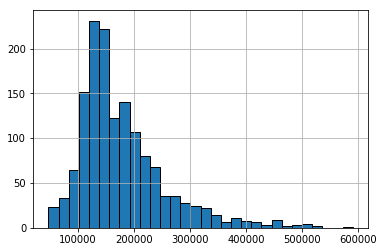

In [84]:
predict_df['SalePrice'].hist(bins=30,edgecolor='black')

In [87]:
predict_df.to_csv('submission_Aug26.csv',columns=['SalePrice'])